### Identification of knock-down resistance (*Kdr*) in Tanzanian *Anopheles. funestus*, 2023.
### Tristan P.W. Dennis, Joel O. Odero 22.11.23

In [1]:
#import libs
import numpy as np
import pandas as pd
import malariagen_data
import allel
import xarray as xr
import malariagen_data
from typing import List
import plotly.express as px
import ipyleaflet
import bokeh
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import _convert_to_double
from scipy.spatial import distance
from scipy.cluster.hierarchy import _hierarchy
import seaborn as sns
import scipy
import matplotlib as mpl

In [3]:
af1 = malariagen_data.Af1(pre=True,results_cache='~/Projects/kdr_funestus_report_2023/data')
#load metadata for all sample sets
sample_sets = ['1236-VO-TZ-OKUMU-VMF00252','1236-VO-TZ-OKUMU-VMF00248','1236-VO-TZ-OKUMU-VMF00261', '1236-VO-TZ-OKUMU-OKFR-TZ-2008', '1236-VO-TZ-OKUMU-VMF00090']
df_samples = af1.sample_metadata(sample_sets=sample_sets)
df_samples = df_samples[df_samples.admin1_name != 'Kigoma']

In [46]:
#plot vgsc transcript
af1.plot_transcript('LOC125769886_t4')

In [49]:
#define pop colours
poppalkeys = df_samples.admin1_name.unique()
poppalvals = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']
pop_colours = dict(zip(sorted(poppalkeys), poppalvals))
pop_colours

{'Dodoma': '#a6cee3',
 'Kagera': '#1f78b4',
 'Katavi': '#b2df8a',
 'Lindi': '#33a02c',
 'Morogoro': '#fb9a99',
 'Mtwara': '#e31a1c',
 'Mwanza': '#fdbf6f',
 'Pwani': '#ff7f00',
 'Ruvuma': '#cab2d6',
 'Tanga': '#6a3d9a'}

Let's start with the genome-wide selection scans. Starting with H12.

In [ ]:
#now do by chrom and cohort H12 selection scan
contigs = ['3RL']
h_list = []
window_size = 2000
for cohort in df_samples.admin1_name.unique():
    for contig in contigs:
        h = af1.h12_gwss(
            contig=contig,
            sample_query=f"admin1_name == '{cohort}'",
            window_size=window_size,
            min_cohort_size=10,
            )
        h = pd.DataFrame({'pos' : h[0], 'h12' : h[1], 'chrom' : contig, 'pop' : cohort})
        h_list.append(h)

h_df = pd.concat(h_list)


Now, let's perform the G123 selection scan to make sure the results are concordant.

In [ ]:
#now do by chrom and cohort H12 selection scan
contigs = ['3RL']
g_list = []
window_size = 1000
for cohort in df_samples.admin1_name.unique():
    for contig in contigs:
        h = af1.g123_gwss(
            contig=contig,
            sample_query=f"admin1_name == '{cohort}'",
            window_size=window_size,
            min_cohort_size=10,
            )
        h = pd.DataFrame({'pos' : h[0], 'g123' : h[1], 'chrom' : contig, 'pop' : cohort})
        g_list.append(h)

g_df = pd.concat(g_list)


Define the plotting function for the scans:

In [73]:
from matplotlib.gridspec import GridSpec

def plot_scan(h_df, xlimleft=None, xlimright=None, stat='h12'):
    max_values = h_df.groupby('chrom')['pos'].max()
    total_max = max_values.sum()
    column_widths = (max_values / total_max).values
    col_var_levels = max_values.index
    vgsc_region = {'3RL': {'x_min': 44105643, 'x_max': 44105644, 'y_min': 0, 'y_max': 1}}


    rowvars_reordered = ['Dodoma', 'Kagera', 'Katavi', 'Lindi', 'Morogoro', 'Mtwara', 'Mwanza', 'Pwani', 'Ruvuma', 'Tanga']

    # Get the unique row and column variables
    row_var_levels = h_df['pop'].unique()

    # Initialize the figure and GridSpec
    fig = plt.figure(figsize=(sum(column_widths) * 12, len(row_var_levels) * 1.5))  # Plots half as high
    gs = GridSpec(len(row_var_levels), len(col_var_levels) + 1, width_ratios=list(column_widths) + [0.1])

    # Create the subplots
    for row_idx, row_val in enumerate(rowvars_reordered):
        for col_idx, col_val in enumerate(col_var_levels):
            row_colour = pop_colours.get(row_val, 'black')  # Default color if not specified

            ax = fig.add_subplot(gs[row_idx, col_idx])
            subset = h_df[(h_df['pop'] == row_val) & (h_df['chrom'] == col_val)]
            sns.lineplot(data=subset, x='pos', y=stat, ax=ax, linewidth=0.5, color=row_colour)
            
            #set xlim if supplied
            if xlimleft:
                ax.set_xlim(left=xlimleft, right=xlimright)
            else:
                pass

            #add some shading underneath the line to look nice
            ax.fill_between(x=subset['pos'], y1=subset[stat], color=row_colour, alpha=0.1)  # Adjust alpha for transparency if needed

            #ax.set_title(f"{row_val} - {col_val}")
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['bottom'].set_visible(False)

            #add vgsc region
            if col_val == '3RL':
                ax.fill_betweenx([vgsc_region[col_val]['y_min'], vgsc_region[col_val]['y_max']],
                                vgsc_region[col_val]['x_min'], vgsc_region[col_val]['x_max'],
                                color='gray', alpha=0.5)

            # Remove x-axis
            ax.set_xlabel('')
            #ax.xaxis.set_visible(False)

            #ax.set_ylim(0, 1)

            
        # Add the row title
        row_ax = fig.add_subplot(gs[row_idx, -1])
        row_ax.text(0.5, 0.5, row_val, va='center', ha='center', fontsize=12, rotation=90, transform=row_ax.transAxes)
        row_ax.axis('off')

    plt.subplots_adjust(wspace=0.01, hspace=0.05)  # Reduce column and row padding
    plt.show()



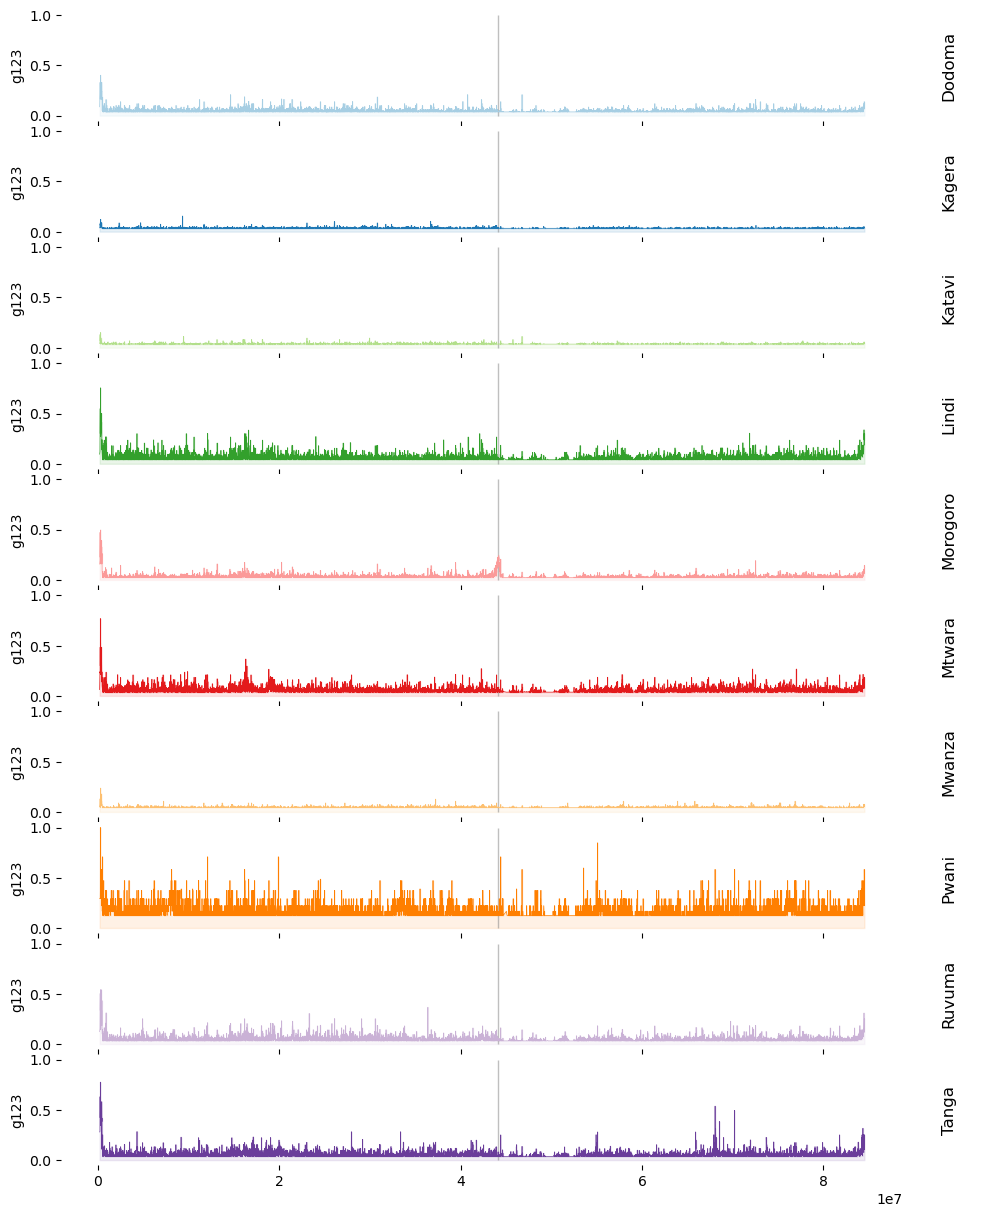

In [74]:
plot_scan(g_df, stat = 'g123')

Now let's plot H12 and see if there is a difference. Will need to make the window size a bit larger.

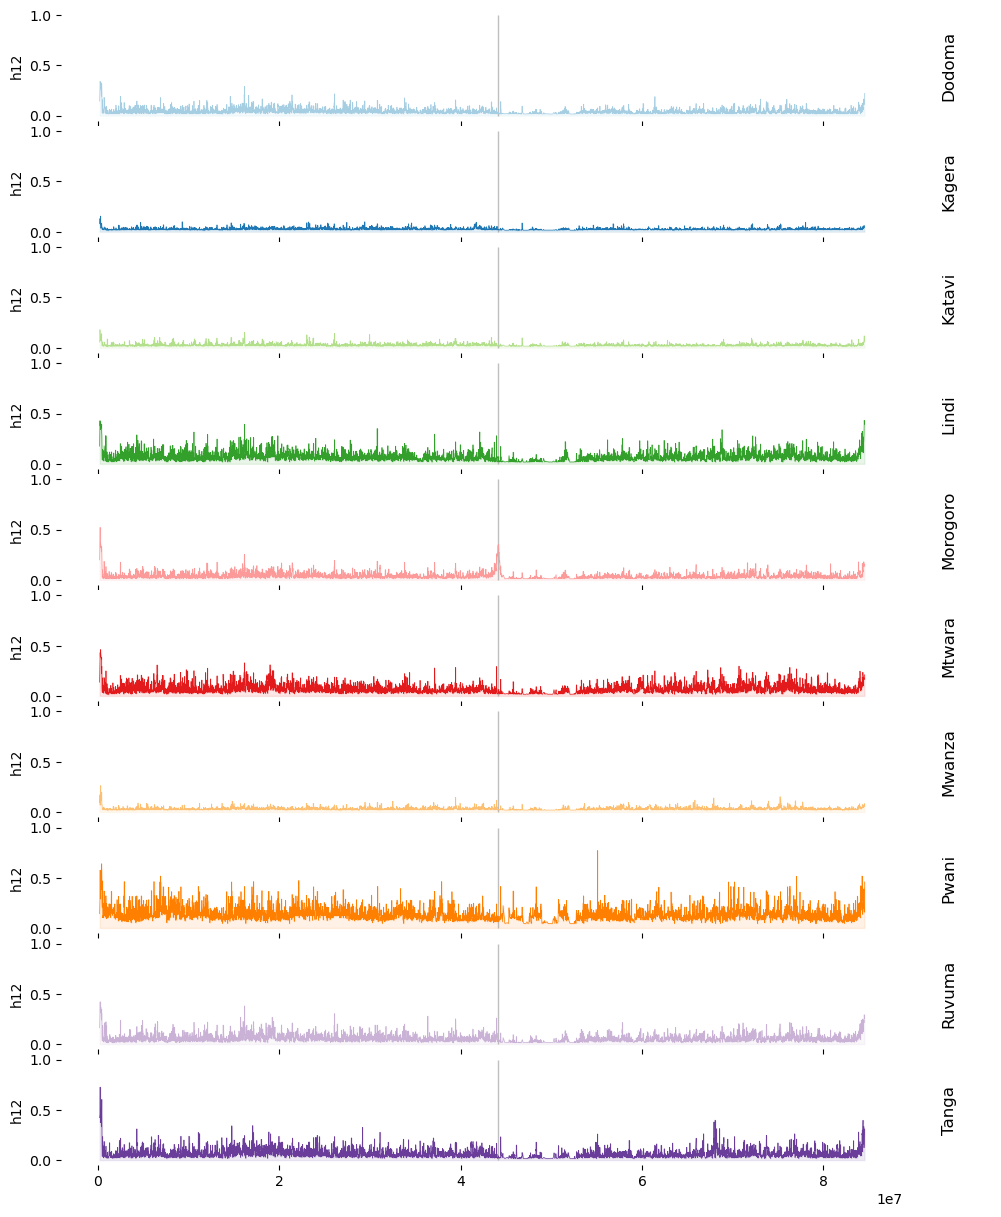

In [75]:
plot_scan(h_df, stat = 'h12')

As expected they look pretty much identical. Let's plot H12, and zoom in in our region of interest (Vgsc, grey line)

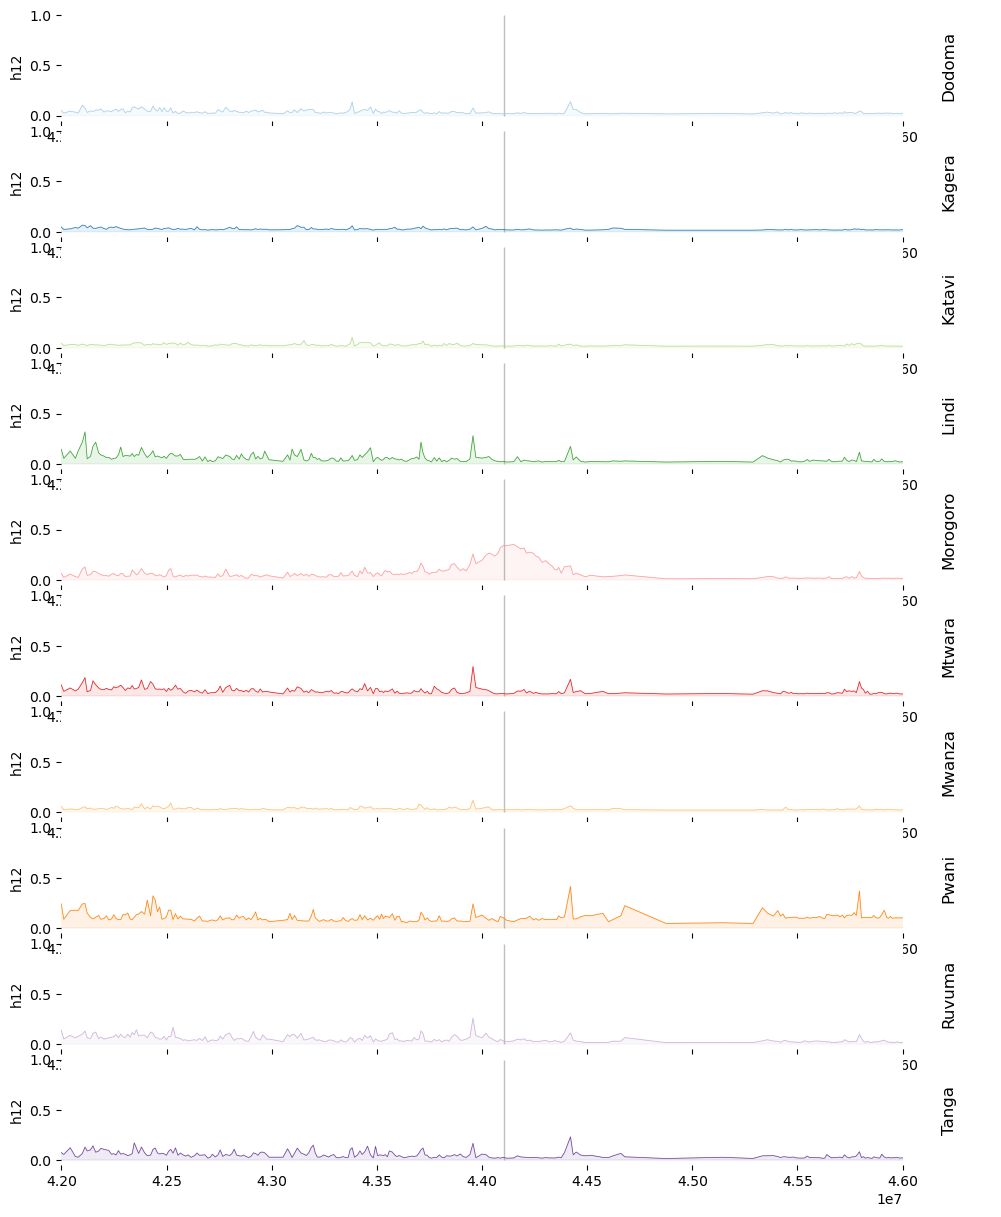

In [76]:
plot_scan(h_df, stat = 'h12', xlimleft=42_000000, xlimright=46_000000)

This looks a lot better, let's use this one for the main text.

Now let's analyse our SNPs in the Vgsc region themselves. Start by making an LD table:

In [20]:
#LD analysis of vgsc gene 

#get snp data
vgsc_genos = af1.snp_genotypes(
    region='3RL:44105643-44156624',
    sample_query="sample_set == ['1236-VO-TZ-OKUMU-VMF00252','1236-VO-TZ-OKUMU-VMF00248','1236-VO-TZ-OKUMU-VMF00261', '1236-VO-TZ-OKUMU-OKFR-TZ-2008', '1236-VO-TZ-OKUMU-VMF00090'] & admin1_name != 'Kigoma'",
)

#get variant data
vars = af1.snp_variants(
    region='3RL:44105643-44156624',
   # sample_query="sample_set == ['1236-VO-TZ-OKUMU-VMF00252','1236-VO-TZ-OKUMU-VMF00248','1236-VO-TZ-OKUMU-VMF00261', '1236-VO-TZ-OKUMU-OKFR-TZ-2008', '1236-VO-TZ-OKUMU-VMF00090']"
)

#compute variant positions and get positions corresponding to our vgsc snps of interest
varpos = vars['variant_position'].values
varvgsc = [44115564,44115768,44116128,44116334,44116923,44117167,44122391,44125475]
snp_indices = np.where(np.isin(varpos, varvgsc))[0]
kdr_genos = allel.GenotypeArray(vgsc_genos).take([9921, 10125, 10485, 10691, 11280, 11524, 16748, 19832], axis=0)

#calculate number of alternate alleles
kdr_numalt = kdr_genos.to_n_alt()

#infer LD and write
ld_r_mat = allel.rogers_huff_r_between(kdr_numalt, kdr_numalt)
df = pd.DataFrame(ld_r_mat)
df.to_csv("/Users/dennistpw/Projects/kdr_funestus_report_2023/data/kdrld.csv")

Load sample metadata:   0%|          | 0/30 [00:00<?, ?it/s]

We will plot these SNPs using R later (I preferred / am more familiar with heatmaps in R because I am a python newbie)

In [21]:
#subset variants to be only the positions we want

#defin dictionary of variants of interest (nonsynonymous mutations over 5%)
analysishaps = {'I2030V' : '44115564',
'G1962V' : '44115768',
'P1842S' : '44116128',
'N1773S' : '44116334',
'F1638Y' : '44116923',
'W1557R' : '44117167',
'G1144C' : '44122391',
'L976F' :  '44125475'}


Now, let's get the time series data:

In [77]:
##nowtime series plot of allele freqs
ds_moro_af = af1.aa_allele_frequencies_advanced(
    transcript='LOC125769886_t4',
    area_by="admin1_iso",  # group samples in space by admin level 1
    period_by="year",  # group samples in time by year
    sample_query="cohort_admin1_year ==['TZ-03_fune_2022', 'TZ-05_fune_2022', 'TZ-12_fune_2022', 'TZ-16_fune_2017', 'TZ-16_fune_2019', 'TZ-16_fune_2021', 'TZ-16_fune_2023', 'TZ-17_fune_2022', 'TZ-18_fune_2023', 'TZ-19_fune_2019', 'TZ-21_fune_2022', 'TZ-25_fune_2022', 'TZ-28_fune_2022'] & admin1_name == 'Morogoro'",
    min_cohort_size= 9,
    variant_query="max_af > 0.1",  # only keep variants above 5% frequency in at least one cohort
)

fig = af1.plot_frequencies_time_series(ds_moro_af, height= 700, template='simple_white')
fig.show()

Load SNP genotypes:   0%|          | 0/12 [00:00<?, ?it/s]

Compute SNP allele frequencies:   0%|          | 0/4 [00:00<?, ?it/s]

Compute SNP effects:   0%|          | 0/2000 [00:00<?, ?it/s]

KeyboardInterrupt: 

Now, let's get the allele frequency data by all cohorts for Vgsc SNPs. Again, we will plot these in R later.

In [ ]:
#make dfs out of all freq data
freq = pd.DataFrame(ds_moro_af.event_frequency.values, columns=ds_moro_af.cohort_period.values,index=ds_moro_af.variant_aa_change.values)
ciu = pd.DataFrame(ds_moro_af.event_frequency_ci_upp.values, columns=ds_moro_af.cohort_period.values,index=ds_moro_af.variant_aa_change.values)
cil = pd.DataFrame(ds_moro_af.event_frequency_ci_low.values, columns=ds_moro_af.cohort_period.values,index=ds_moro_af.variant_aa_change.values)
#add label col
ciu['val'] = 'ci_up'
cil['val'] = 'ci_low'
freq['val'] = 'freq'
freqdf = pd.concat([freq, ciu, cil])
freqdf.to_csv('~/Projects/kdr_funestus_report_2023/tables/kdr_freqs.csv')

Finally, let's perform some haplotype clustering. Way back when (6 months ago) I found this all a bit daunting but I really liked Chris Clarksons's 2021 Kdr paper and they way they plotted population and haplotype structure below the dendrogram. This code is lifted straight from the repo he published with that paper. Thanks Chris!

In [ ]:
#get hap data
vgsc_haps = af1.haplotypes(
    region='3RL:44105643-44156624',
    sample_query="sample_set == ['1236-VO-TZ-OKUMU-VMF00252','1236-VO-TZ-OKUMU-VMF00248','1236-VO-TZ-OKUMU-VMF00261', '1236-VO-TZ-OKUMU-OKFR-TZ-2008', '1236-VO-TZ-OKUMU-VMF00090'] & admin1_name != 'Kigoma'",
)

#compute hap positions and get positions corresponding to our vgsc haps of interest
happos = vgsc_haps['variant_position'].values
varvgsc = [44116128,44116923,44117167,44125475]
hap_indices = np.where(np.isin(happos, varvgsc))[0]

#compute haplotypearray and keep missense muts 
gt = allel.GenotypeDaskArray(vgsc_haps["call_genotype"].data)
ht = gt.to_haplotypes().compute()
kdr_haps = ht.take(hap_indices.tolist(), axis=0)


In [23]:
def plot_missense_haplotypes(ax, h, mut_labels):
    h = h.copy()
    # colours for colormap
    mycol = ['r', 'w', 'k'] 
    # alter rows with kdr mutations for color map to pick up
#     known_muts = ['L995S (2984T>C)', 'L995F (2985A>T)', 'N1570Y (4708A>T)']
    known_muts = ['L976F', 'F1638Y','W1557R','P1842S']
    for mut in known_muts:
        if mut in mut_labels:
            h[mut_labels.index(mut)] *= -1

    # make colormap
    cake = mpl.colors.ListedColormap(mycol, name='mymap', N=3)
    # plot
    ax.pcolormesh(np.asarray(h[::-1]), cmap=cake, vmin=-1, vmax=1, zorder=-10)
        
    ax.set_yticks(np.arange(h.shape[0])+.5)
    lbl = [l for l in mut_labels[::-1]]
    ax.set_yticklabels(lbl, family='monospace', fontsize=6)
    ax.set_ylabel('Non-synonymous SNPs')
    
    for ytick in ax.get_yticklabels():
        if ytick.get_text() in known_muts:
            ytick.set_color('r')
    
    ax.hlines(np.arange(h.shape[0]+1), 0, h.shape[1], color='k', lw=.5)
    ax.set_xlim(0, h.shape[1])
    ax.set_ylim(0, h.shape[0])
    ax.yaxis.tick_left()
    ax.set_xticks([])
    # rasterize to avoid SVG antialiasing issues and reduce file size
    ax.set_rasterization_zorder(-5)

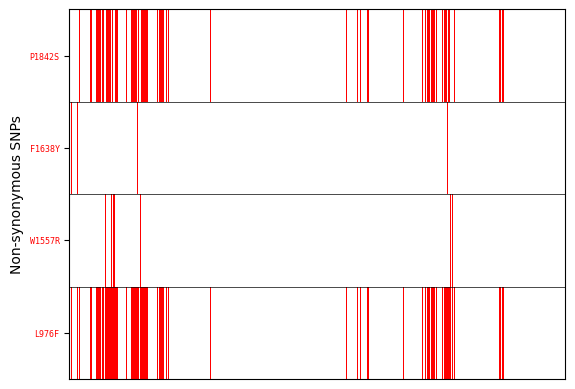

In [24]:
fig, ax = plt.subplots()
missense_mutations = ['P1842S', 'F1638Y','W1557R','L976F']
plot_missense_haplotypes(ax, kdr_haps, missense_mutations)

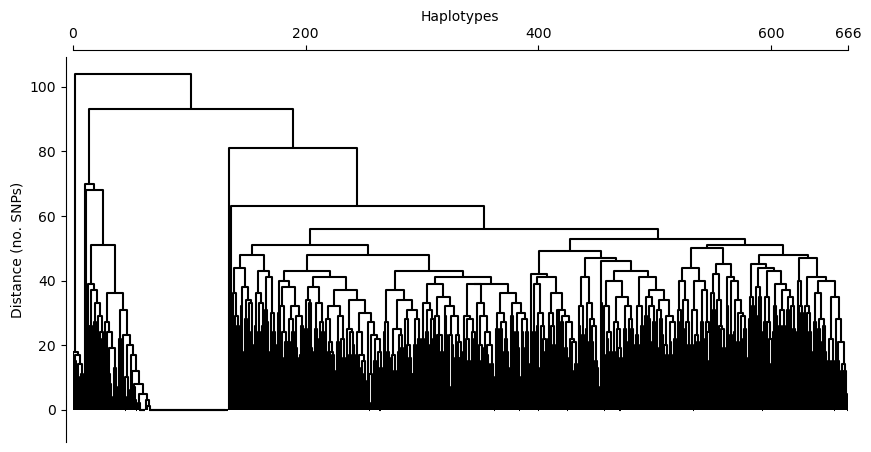

In [25]:
def plot_dendrogram(h, ax, method='complete', color_threshold=0, above_threshold_color='k'):
    
    # compute distance matrix
    dist = allel.pairwise_distance(h, 'hamming') * h.shape[0]

    # HACKING SCIPY TO GET TO OLD CLUSTERING METHOD
    # https://github.com/scipy/scipy/blob/v0.18.1/scipy/cluster/hierarchy.py#L470-L667
    # 1. fiddle with format
    y = _convert_to_double(np.asarray(dist, order='c'))
    # 2. get n
    n = int(distance.num_obs_y(dist))
    # 3. do clustering
    method = dict(single=0, complete=1)[method]
    z = _hierarchy.linkage(y, n, method)    

    # plot dendrogram
    sns.despine(ax=ax, offset=5, bottom=True, top=False)
    r = scipy.cluster.hierarchy.dendrogram(z, no_labels=True, count_sort=True, 
                                           color_threshold=color_threshold, 
                                           above_threshold_color=above_threshold_color,
                                           ax=ax)
    xmin, xmax = ax.xaxis.get_data_interval()
    xticklabels = np.array(list(range(0, h.shape[1], 200)) + [h.shape[1]])
    xticks = xticklabels / h.shape[1]
    xticks = (xticks * (xmax - xmin)) + xmin
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_xlabel('Haplotypes')
    ax.xaxis.set_label_position('top')
    ax.set_ylim(bottom=-10)
#     ax.set_xlim(left=-10)
    ax.set_ylabel('Distance (no. SNPs)')
    ax.autoscale(axis='x', tight=True)
    return z, r

fig, ax = plt.subplots(figsize=(10, 5))
plot_dendrogram(ht, ax);

In [26]:
#define hap and pop dfs for plotting
df_haps = df_samples.loc[df_samples.index.repeat(2)]
populations = df_samples.admin1_name
pop_labels = df_samples.admin1_name.values

In [27]:
def fig_hap_structure(h, h_display=None, mutations=None, vspans=[[]], cluster_labels=[], figsize=(10, 8), 
                      fn=None, dpi=150, height_ratios=(3, .2, 1.5, .2), hap_pops=None, legend=True):
    
    # create the figure
    fig = plt.figure(figsize=figsize)
    
    # define subplot layout
    gs_nrows = 4
    gs_ncols = 1
    gs = mpl.gridspec.GridSpec(gs_nrows, gs_ncols, hspace=0.04, wspace=0.04,
                               height_ratios=height_ratios)
    
    # dendrogram
    ax_dend = fig.add_subplot(gs[0, 0])
    z, r = plot_dendrogram(h, ax_dend, color_threshold=0)
    ax_dend.set_ylim(bottom=-5)
#     for xmin, xmax in vspans:
#         ax.add_patch(plt.Rectangle((xmin, 0), (xmax-xmin), 1,
#                                    facecolor='k', edgecolor='k', alpha=.1,
#                                    transform=ax.transAxes, zorder=20))
#     ax.vlines(vspans.flat, 0, 1, transform=ax.transAxes, linestyle=':')
    if legend:
        handles = [mpl.patches.Patch(color=pop_colours[pop], label=pop) for pop in poppalkeys]
        ax_dend.legend(handles=handles, loc='upper right', bbox_to_anchor=(1, 1), ncol=3)
    ax_dend.set_yticklabels(ax_dend.get_yticks().astype(int))
    ax_dend.xaxis.set_tick_params(length=3, pad=2)
    ax_dend.yaxis.set_tick_params(length=3, pad=2)

    # population colours
    ax_pops = fig.add_subplot(gs[1, 0])
    if hap_pops is None:
        hap_pops = df_haps.admin1_name.values
    x = hap_pops.take(r['leaves'])
    hap_clrs = [pop_colours[p] for p in x]
    ax_pops.broken_barh(xranges=[(i, 1) for i in range(h.shape[1])], yrange=(0, 1), color=hap_clrs);
    sns.despine(ax=ax_pops, offset=5, left=True, bottom=True)
    ax_pops.set_xticks([])
    ax_pops.set_yticks([])
    ax_pops.set_xlim(0, h.shape[1])
    ax_pops.yaxis.set_label_position('left')
    ax_pops.set_ylabel('Population', rotation=0, ha='right', va='center')

    # missense mutations
    if h_display is not None:
        ax_mut = fig.add_subplot(gs[2, 0])
        plot_missense_haplotypes(ax_mut, h_display.take(r['leaves'], axis=1), mutations)
        ax_mut.set_xticks([])
        ax_mut.yaxis.set_tick_params(length=3, pad=2)

    # KDR haplotype clusters
    ax_clu = fig.add_subplot(gs[3, 0])
    sns.despine(ax=ax_clu, bottom=True, left=True)
    ax_clu.set_xlim(0, h.shape[1])
    ax_clu.set_ylim(0, 1)
    for lbl, (xmin, xmax) in zip(cluster_labels, vspans):
        if lbl:
            # hack to get the "fraction" right, which controls length of bracket arms
            fraction = -20 / (xmax - xmin)
            ax_clu.annotate("", ha='left', va='center',
                            xy=(xmin, 1), xycoords='data',
                            xytext=(xmax, 1), textcoords='data',
                            arrowprops=dict(arrowstyle="-",
                                            connectionstyle="bar,fraction=%.4f" % fraction,
                                            ),
                            )
            ax_clu.text((xmax + xmin)/2, 0.2, lbl, va='top', ha='center', fontsize=6)
            ax_pops.vlines([xmin, xmax], 0, 1, linestyle=':')
            ax_mut.add_patch(plt.Rectangle((xmin, 0), (xmax-xmin), h_display.shape[0],
                             facecolor='k', edgecolor='k', alpha=.1,
                             zorder=20))
            ax_mut.vlines([xmin, xmax], 0, h_display.shape[0], linestyle=':')
    ax_clu.set_xticks([])
    ax_clu.set_yticks([])
    ax_clu.set_xlabel('$kdr$ haplotype clusters')
    
    if fn:
        fig.savefig(fn, jpeg_quality=100, dpi=dpi, bbox_inches='tight')
        
    return z, r

/var/folders/bs/sb5__dq153x37170dk1vr_2h0000gp/T/ipykernel_56004/4128140202.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_dend.set_yticklabels(ax_dend.get_yticks().astype(int))


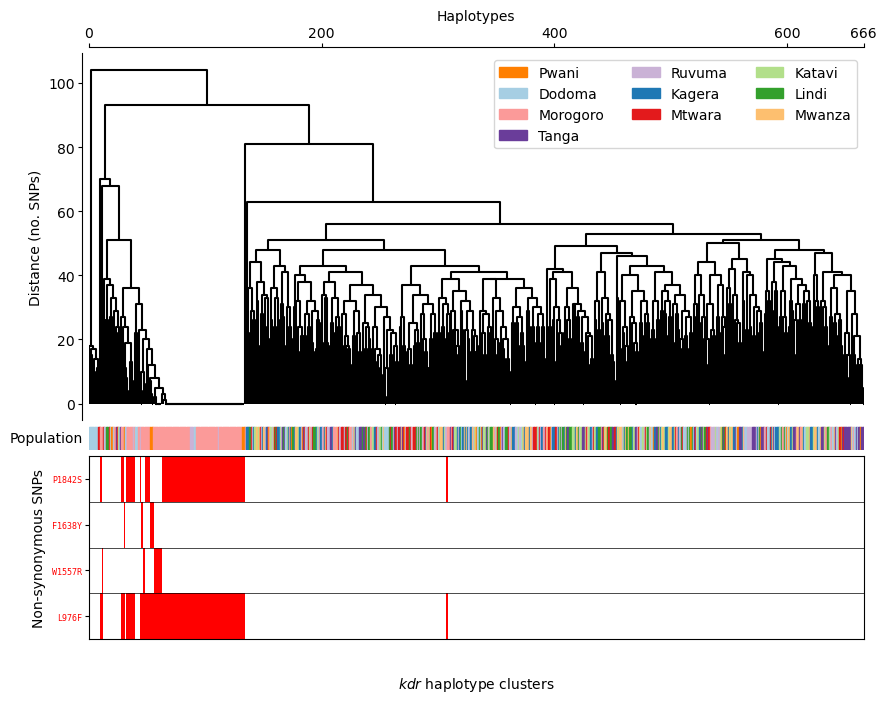

In [28]:
z, r = fig_hap_structure(ht, kdr_haps, missense_mutations)

Looking good! We can see very clearly the (by Vgsc standards) weak sweep involving L976F and, also, P1842S, mainly confined to Morogoro region.
